In [1]:
# import json
# import cv2
# import matplotlib.pyplot as plt

# Problem Description:

We have 2 files: *file1.json* and *file2.json*

We aim to generate: *file3.json* and quadrant image patches

---
---
---
---
---

*file1.json* obtained from Model1 when running q-e labelled data through it.
This should/will have the following format:


```
"images": [{"id": 1, "file_name": "train_673.png"}, ... ]

"annotations": [{"image_id": 1, "bbox": [1453.92, 332.24, 624.52, 467.92],
                                    "id": 1, "category_id": 3}, ... ]
```
With the following category_id mapping:
```
"categories": [{"id":0,"name":"2","supercategory":"2"},     #top-right
                             {"id":1,"name":"1","supercategory":"1"},     #top-left
                             {"id":2,"name":"3","supercategory":"3"},     #bottom-right
                             {"id":3,"name":"4","supercategory":"4"}]     #bottom-left
```
Under annotations, there must be 4 dictionaries for each image_id. [each image has 4 quadrants]

The dictionaries may contain more data but the fields shown here are **needed**.


---
---
---


*file2.json* which we already have as a part of the q-e training data has the following format:
```
"images": [{"height": 1316, "width": 2710, "id": 1, "file_name": "train_283.png"}, ... ]

"annotations": [{"iscrowd": 0, "image_id": 1, "bbox": [1283.33, 459.25, 100.0, 262.03],
                                 "segmentation": [[1366, 459, 1383, 662, 1380, 716, 1295, 721, 1288, 659, 1283, 464]],
                                 "id": 1, "area": 22904, "category_id_1": 0, "category_id_2": 0}, ... ]

"categories_1": [{"id": 0, "name": 1, "supercategory": 1},        #top-left
                                 {"id": 1, "name": 2, "supercategory": 2},        #top-right
                                 {"id": 2, "name": 3, "supercategory": 3},        #bottom-right
                                 {"id": 3, "name": 4, "supercategory": 4}],     #bottom-left
    
"categories_2": [{"id": 0, "name": "1", "supercategory": "1"},
                                 {"id": 1, "name": "2", "supercategory": "2"},
                                 {"id": 2, "name": "3", "supercategory": "3"},
                                 {"id": 3, "name": "4", "supercategory": "4"},
                                 {"id": 4, "name": "5", "supercategory": "5"},
                                 {"id": 5, "name": "6", "supercategory": "6"},
                                 {"id": 6, "name": "7", "supercategory": "7"},
                                 {"id": 7, "name": "8", "supercategory": "8"}]
```
The "images" set of dictionaries should be the same in both files.

As can be seen, for the same quadrant, both files use a different ID. Therefore the team handling *file1.json* generation must ensure to **change** the ID mapping when it comes to the quadrant categories such that it matches the mapping in *file2.json*.

Not every mouth has 32 teeth so the category IDs for both quadrant and enumeration are required.

In this file, the image_id will be used to refer to the same OG image and will be used for mapping between the 2 data files.

---
---
---
---
---


GENERATION OF *file3.json* and image patches for each quadrant:

For a given image_id:

1. Using the info in *file1.json* to
        1. create padded quadrant image patches with image_id mappings and
        2. store the bb annotation for each quadrant and also border thickness
        3. adjust these patches so that they are all in the same orientation:
                1. Quadrant 1 (top-left) left unchanged
                2. Quadrant 2 (top-right) flipped horizontally
                3. Quadrant 3 (bottom-right) flipped horizontally and vertically
                4. Quadrant 4 (bottom-left) flipped vertically

2. Use the info in *file2.json* to
        1. for each tooth bb, assign a new image_id that corresponds to the newly created quadrant image
        2. adjust bb values according to which quadrant it falls in (flipping) and then move again to compensate for the padding
        3. Keep track of both original image_id and quadrant_image_id

Therefore, the format for *file3.json* will be:

```
"images": [{"height": 1316, "width": 2710, "id": 1, "file_name": "train_283.png"}, ... ]

"q-patches": [{"height": 467, "width": 673, "image_id": 1, "id": 3, "category":3, "file_name": "qpatch_3.png"}, ... ]

"annotations": [{"image_id": 1, "q_image_id": 3,
                                 "bbox": [1283.3333333333333, 459.25925925925924, 100.0, 262.03703703703707],    
                                 "id": 1, "category_id_1": 0, "category_id_2": 0}, ... ]

"categories_1": [{"id": 0, "name": 1, "supercategory": 1},        #top-left
                                 {"id": 1, "name": 2, "supercategory": 2},        #top-right
                                 {"id": 2, "name": 3, "supercategory": 3},        #bottom-right
                                 {"id": 3, "name": 4, "supercategory": 4}],     #bottom-left
    
"categories_2": [{"id": 0, "name": "1", "supercategory": "1"},
                                 {"id": 1, "name": "2", "supercategory": "2"},
                                 {"id": 2, "name": "3", "supercategory": "3"},
                                 {"id": 3, "name": "4", "supercategory": "4"},
                                 {"id": 4, "name": "5", "supercategory": "5"},
                                 {"id": 5, "name": "6", "supercategory": "6"},
                                 {"id": 6, "name": "7", "supercategory": "7"},
                                 {"id": 7, "name": "8", "supercategory": "8"}]
```

# Checking Qudrant Mapping in q-data:

In [2]:
# dic1 = {"iscrowd":0,"image_id":2,"bbox":[1480.25,203.375,668.75,481.25],"category_id":0,"id":5,"area":188574}
# dic2 = {"iscrowd":0,"image_id":2,"bbox":[845.875,272.125,643.75,425.0],"category_id":1,"id":6,"area":183056}
# dic3 = {"iscrowd":0,"image_id":2,"bbox":[1505.25,387.75,803.125,671.875],"category_id":2,"id":7,"area":253515}
# dic4 = {"iscrowd":0,"image_id":2,"bbox":[705.25,484.625,853.125,584.375],"category_id":3,"id":8,"area":248803}

In [3]:
# image = cv2.imread("train_283.png")
# for dic in [dic1, dic2, dic3, dic4]:
#     x_min, y_min, width, height = dic['bbox'][:]

#     x_max = x_min + width
#     y_max = y_min + height

#     if dic["category_id"] == 0:
#         color = (255, 0, 0)        #red
#     elif dic["category_id"] == 1:
#         color = (0, 255, 0)        #green
#     elif dic["category_id"] == 2:
#         color = (0, 0, 255)     #blue
#     elif dic["category_id"] == 3:
#         color = (0, 0,0)            #black
#     thickness = 5
#     cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), color, thickness)

# plt.imshow(image)

# Checking Quadrant Mapping in q-e data:

In [4]:
# ##{"height": 1316, "width": 2710, "id": 1, "file_name": "train_283.png"}
# annotations = [{"iscrowd": 0, "image_id": 1, "bbox": [1283.3333333333333, 459.25925925925924, 100.0, 262.03703703703707], "segmentation": [[1366, 459, 1383, 662, 1380, 716, 1295, 721, 1288, 659, 1283, 464]], "id": 1, "area": 22904, "category_id_1": 0, "category_id_2": 0}, {"iscrowd": 0, "image_id": 1, "bbox": [1200.0, 460.18518518518516, 90.74074074074065, 264.81481481481484], "segmentation": [[1290, 463, 1290, 619, 1276, 719, 1224, 725, 1200, 699, 1203, 648, 1219, 573, 1236, 460]], "id": 2, "area": 18597, "category_id_1": 0, "category_id_2": 1}, {"iscrowd": 0, "image_id": 1, "bbox": [1100.9259259259259, 451.85185185185185, 119.44444444444434, 302.7777777777777], "segmentation": [[1162, 451, 1212, 637, 1218, 663, 1220, 679, 1219, 700, 1200, 732, 1179, 754, 1151, 738, 1114, 706, 1100, 462]], "id": 3, "area": 24808, "category_id_1": 0, "category_id_2": 2}, {"iscrowd": 0, "image_id": 1, "bbox": [914.8148148148148, 466.66666666666663, 174.07407407407413, 312.03703703703707], "segmentation": [[965, 466, 1050, 562, 1088, 709, 1088, 760, 1060, 778, 1031, 767, 1002, 756, 984, 749, 983, 718, 977, 648, 914, 487]], "id": 4, "area": 28017, "category_id_1": 0, "category_id_2": 4}, {"iscrowd": 0, "image_id": 1, "bbox": [822.2222222222222, 484.25925925925924, 182.4074074074074, 317.5925925925926], "segmentation": [[915, 484, 981, 671, 997, 700, 1002, 721, 1004, 747, 1004, 774, 991, 786, 963, 799, 940, 801, 912, 801, 886, 788, 871, 768, 868, 709, 834, 578, 822, 518]], "id": 5, "area": 35576, "category_id_1": 0, "category_id_2": 5}, {"iscrowd": 0, "image_id": 1, "bbox": [729.6296296296296, 494.4444444444444, 143.51851851851848, 289.81481481481484], "segmentation": [[790, 494, 822, 556, 845, 592, 860, 637, 870, 725, 873, 767, 848, 782, 821, 784, 794, 775, 783, 771, 764, 769, 749, 763, 739, 757, 740, 710, 750, 639, 729, 517]], "id": 6, "area": 29269, "category_id_1": 0, "category_id_2": 6}, {"iscrowd": 0, "image_id": 1, "bbox": [609.2592592592592, 500.92592592592587, 142.5925925925926, 254.62962962962968], "segmentation": [[672, 503, 609, 724, 703, 755, 735, 755, 751, 677, 749, 602, 721, 500]], "id": 7, "area": 25191, "category_id_1": 0, "category_id_2": 7}, {"iscrowd": 0, "image_id": 1, "bbox": [1377.7777777777776, 450.9259259259259, 100.0, 268.5185185185184], "segmentation": [[1387, 450, 1377, 714, 1418, 719, 1461, 717, 1477, 669, 1476, 459]], "id": 8, "area": 24466, "category_id_1": 1, "category_id_2": 0}, {"iscrowd": 0, "image_id": 1, "bbox": [1476.8518518518517, 460.18518518518516, 100.0, 246.29629629629625], "segmentation": [[1486, 460, 1490, 556, 1476, 672, 1488, 697, 1506, 706, 1528, 706, 1547, 698, 1562, 672, 1576, 472]], "id": 9, "area": 19440, "category_id_1": 1, "category_id_2": 1}, {"iscrowd": 0, "image_id": 1, "bbox": [1555.5555555555554, 428.7037037037037, 137.96296296296305, 310.1851851851851], "segmentation": [[1629, 449, 1578, 568, 1565, 621, 1560, 661, 1555, 687, 1556, 712, 1568, 725, 1580, 733, 1593, 737, 1605, 738, 1627, 725, 1643, 700, 1645, 666, 1653, 566, 1693, 444, 1639, 428]], "id": 10, "area": 22296, "category_id_1": 1, "category_id_2": 2}, {"iscrowd": 0, "image_id": 1, "bbox": [1632.4074074074074, 497.2222222222222, 106.4814814814813, 255.55555555555554], "segmentation": [[1667, 497, 1650, 630, 1637, 700, 1632, 737, 1670, 752, 1708, 739, 1731, 701, 1738, 499]], "id": 11, "area": 20300, "category_id_1": 1, "category_id_2": 3}, {"iscrowd": 0, "image_id": 1, "bbox": [1723.148148148148, 492.59259259259255, 177.77777777777783, 303.70370370370364], "segmentation": [[1817, 492, 1723, 754, 1783, 792, 1842, 796, 1865, 776, 1870, 743, 1872, 703, 1900, 505]], "id": 12, "area": 33574, "category_id_1": 1, "category_id_2": 5}, {"iscrowd": 0, "image_id": 1, "bbox": [1868.5185185185185, 481.48148148148147, 128.7037037037037, 306.48148148148147], "segmentation": [[1918, 496, 1874, 633, 1869, 701, 1868, 745, 1877, 773, 1892, 780, 1906, 786, 1928, 787, 1967, 769, 1979, 754, 1974, 709, 1997, 482, 1923, 481]], "id": 13, "area": 29389, "category_id_1": 1, "category_id_2": 6}, {"iscrowd": 0, "image_id": 1, "bbox": [1976.8518518518517, 508.3333333333333, 125.9259259259261, 274.99999999999994], "segmentation": [[2037, 508, 1989, 611, 1982, 670, 1976, 719, 1976, 750, 1986, 779, 2021, 783, 2057, 775, 2087, 730, 2093, 654, 2102, 513]], "id": 14, "area": 26320, "category_id_1": 1, "category_id_2": 7}, {"iscrowd": 0, "image_id": 1, "bbox": [1368.5185185185185, 735.1851851851851, 74.07407407407413, 283.33333333333337], "segmentation": [[1368, 746, 1386, 1018, 1442, 1003, 1432, 844, 1437, 823, 1429, 735]], "id": 15, "area": 16042, "category_id_1": 2, "category_id_2": 0}, {"iscrowd": 0, "image_id": 1, "bbox": [1433.3333333333333, 726.8518518518518, 78.7037037037037, 255.55555555555554], "segmentation": [[1435, 727, 1433, 802, 1435, 961, 1435, 982, 1471, 981, 1490, 825, 1499, 794, 1509, 774, 1512, 736, 1500, 726, 1467, 726]], "id": 16, "area": 14153, "category_id_1": 2, "category_id_2": 1}, {"iscrowd": 0, "image_id": 1, "bbox": [1494.4444444444443, 736.1111111111111, 99.07407407407413, 375.92592592592587], "segmentation": [[1527, 736, 1515, 756, 1506, 776, 1495, 795, 1494, 815, 1510, 1090, 1516, 1112, 1593, 1106, 1575, 941, 1573, 865, 1577, 803, 1577, 765]], "id": 17, "area": 27509, "category_id_1": 2, "category_id_2": 2}, {"iscrowd": 0, "image_id": 1, "bbox": [1616.6666666666665, 756.4814814814814, 145.37037037037044, 337.03703703703707], "segmentation": [[1650, 758, 1616, 809, 1662, 1061, 1747, 1093, 1762, 1020, 1731, 919, 1729, 816, 1724, 756]], "id": 18, "area": 32015, "category_id_1": 2, "category_id_2": 4}, {"iscrowd": 0, "image_id": 1, "bbox": [1742.5925925925924, 793.5185185185185, 265.7407407407409, 279.62962962962956], "segmentation": [[1799, 799, 1769, 814, 1746, 847, 1742, 886, 1775, 939, 1830, 1006, 1898, 1073, 2008, 1005, 1921, 916, 1887, 864, 1879, 823, 1870, 798, 1844, 793, 1820, 794]], "id": 19, "area": 37436, "category_id_1": 2, "category_id_2": 6}, {"iscrowd": 0, "image_id": 1, "bbox": [1874.9999999999998, 777.51677852349, 218.51851851851848, 217.85359184688036], "segmentation": [[1916, 795, 1882, 804, 1874, 822, 1878, 846, 1888, 874, 1924, 910, 1973, 955, 2059, 995, 2093, 916, 2008, 853, 1981, 800, 1953, 780, 1939, 777, 1924, 788]], "id": 20, "area": 23726, "category_id_1": 2, "category_id_2": 7}, {"iscrowd": 0, "image_id": 1, "bbox": [1313.2780082987551, 739.4190871369294, 72.19917012448127, 247.71784232365144], "segmentation": [[1368, 739, 1385, 985, 1336, 987, 1316, 809, 1313, 742]], "id": 21, "area": 13222, "category_id_1": 3, "category_id_2": 0}, {"iscrowd": 0, "image_id": 1, "bbox": [1250.2074688796679, 734.4398340248962, 85.06224066390041, 261.8257261410788], "segmentation": [[1309, 739, 1335, 986, 1273, 996, 1258, 817, 1259, 800, 1251, 765, 1250, 737, 1266, 734, 1288, 737]], "id": 22, "area": 15326, "category_id_1": 3, "category_id_2": 1}, {"iscrowd": 0, "image_id": 1, "bbox": [1176.3485477178422, 739.0041493775933, 107.0539419087138, 359.75103734439824], "segmentation": [[1233, 739, 1259, 805, 1283, 1087, 1204, 1098, 1190, 899, 1191, 862, 1190, 845, 1189, 825, 1183, 804, 1176, 778, 1206, 739]], "id": 23, "area": 25925, "category_id_1": 3, "category_id_2": 2}, {"iscrowd": 0, "image_id": 1, "bbox": [1100.0, 755.1867219917012, 96.6804979253111, 388.7966804979253], "segmentation": [[1147, 756, 1185, 802, 1196, 817, 1192, 836, 1191, 857, 1190, 876, 1190, 900, 1193, 1028, 1189, 1143, 1122, 1125, 1119, 968, 1110, 843, 1104, 823, 1100, 807, 1101, 791, 1130, 755]], "id": 24, "area": 27437, "category_id_1": 3, "category_id_2": 3}, {"iscrowd": 0, "image_id": 1, "bbox": [1016.5975103734439, 777.1784232365145, 108.71369294605813, 356.01659751037334], "segmentation": [[1077, 780, 1092, 790, 1106, 797, 1112, 808, 1114, 819, 1112, 832, 1110, 850, 1125, 1015, 1121, 1133, 1047, 1125, 1035, 1034, 1048, 998, 1020, 891, 1016, 821, 1016, 800, 1030, 792, 1043, 784, 1060, 777]], "id": 25, "area": 29527, "category_id_1": 3, "category_id_2": 4}, {"iscrowd": 0, "image_id": 1, "bbox": [702.0746887966804, 790.8713692946058, 261.4107883817427, 306.22406639004157], "segmentation": [[831, 790, 818, 804, 809, 817, 803, 829, 799, 842, 797, 857, 790, 880, 702, 1046, 818, 1097, 933, 906, 963, 840, 929, 808, 870, 795]], "id": 26, "area": 41017, "category_id_1": 3, "category_id_2": 6}, {"iscrowd": 0, "image_id": 1, "bbox": [543.1535269709543, 752.6970954356846, 280.9128630705394, 272.19917012448127], "segmentation": [[702, 752, 668, 755, 653, 784, 590, 895, 543, 957, 625, 1024, 673, 1024, 732, 961, 777, 888, 804, 861, 816, 847, 824, 835, 824, 821, 821, 811, 805, 787, 784, 780, 755, 766, 730, 759, 708, 756]], "id": 27, "area": 43292, "category_id_1": 3, "category_id_2": 7}]

In [5]:
# image = cv2.imread("train_283(1).png")
# for dic in annotations:
#     x_min, y_min, width, height = dic['bbox'][:]

#     x_max = x_min + width
#     y_max = y_min + height

#     if dic["category_id_1"] == 0:
#         color = (255, 0, 0)        #red
#     elif dic["category_id_1"] == 1:
#         color = (0, 255, 0)     #green
#     elif dic["category_id_1"] == 2:
#         color = (0, 0, 255)     #blue
#     elif dic["category_id_1"] == 3:
#         color = (0, 0,0)            #black
#     thickness = 5
#     cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), color, thickness)

# plt.imshow(image)

# aa

## experimenting with dict to pd.dataframe:

In [6]:
# with open("train_quadrant.json", 'r') as f:
#     stats1 = json.load(f)
# imagesdf = pd.DataFrame.from_dict(stats1["images"], orient='columns')

In [7]:
# imagesdf.head()

In [8]:
# imagesdf.iloc[0]['file_name']

# Implementing the mapping:

In [9]:
import os
import cv2
import json
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

#set these variables before running:

# # for uncompressed
# file1add = "/raid/infolab/bhavyakohli/mmdet/Co-DETR/data/enumeration/quadrants_of_enumeration_data.json"         #address of file1.json
# file2add = "/raid/infolab/bhavyakohli/mmdet/Co-DETR/data/enumeration/train_enumeration_og.json"         #address of file2.json
# file3add = "/raid/infolab/bhavyakohli/mmdet/Co-DETR/data/enumeration/train_enumeration.json"         #address of directory where file3.json should go
# oglocation = "/raid/infolab/bhavyakohli/mmdet/mmdetection/data/training_data/quadrant_enumeration/xrays/"     #location of folder that contains original images
# qlocation = "/raid/infolab/bhavyakohli/mmdet/Co-DETR/data/enumeration/quadrant_patches/"        #location of folder where q-patches are to be stored


# for compressed 2
file1add = "/raid/infolab/bhavyakohli/mmdet/Co-DETR/data/wave2_enum/quadrants_of_enumeration_data.json"         #address of file1.json
file2add = "/raid/infolab/bhavyakohli/mmdet/Co-DETR/data/wave2_enum/train_enumeration_og.json"         #address of file2.json
file3add = "/raid/infolab/bhavyakohli/mmdet/Co-DETR/data/wave2_enum/train_enumeration.json"         #address of directory where file3.json should go
oglocation = "/raid/infolab/bhavyakohli/mmdet/mmdetection/data/training_data/compressed2/quadrant_enumeration/xrays/"     #location of folder that contains original images
qlocation = "/raid/infolab/bhavyakohli/mmdet/Co-DETR/data/wave2_enum/quadrant_patches/"        #location of folder where q-patches are to be stored


# # for compressed 3
# file1add = "/raid/infolab/bhavyakohli/mmdet/Co-DETR/data/wave3_enum/quadrants_of_enumeration_data.json"         #address of file1.json
# file2add = "/raid/infolab/bhavyakohli/mmdet/Co-DETR/data/wave3_enum/train_enumeration_og.json"         #address of file2.json
# file3add = "/raid/infolab/bhavyakohli/mmdet/Co-DETR/data/wave3_enum/train_enumeration.json"         #address of directory where file3.json should go
# oglocation = "/raid/infolab/bhavyakohli/mmdet/mmdetection/data/training_data/Compressed_training_data/quadrant_enumeration/xrays/"     #location of folder that contains original images
# qlocation = "/raid/infolab/bhavyakohli/mmdet/Co-DETR/data/wave3_enum/quadrant_patches/"        #location of folder where q-patches are to be stored

# # for compressed 4
# file1add = "/raid/infolab/bhavyakohli/mmdet/Co-DETR/data/wave4_enum/quadrants_of_enumeration_data.json"         #address of file1.json
# file2add = "/raid/infolab/bhavyakohli/mmdet/Co-DETR/data/wave4_enum/train_enumeration_og.json"         #address of file2.json
# file3add = "/raid/infolab/bhavyakohli/mmdet/Co-DETR/data/wave4_enum/train_enumeration.json"         #address of directory where file3.json should go
# oglocation = "/raid/infolab/bhavyakohli/mmdet/mmdetection/data/training_data/compressed4/quadrant_enumeration/xrays/"     #location of folder that contains original images
# qlocation = "/raid/infolab/bhavyakohli/mmdet/Co-DETR/data/wave4_enum/quadrant_patches/"        #location of folder where q-patches are to be stored


os.makedirs(qlocation, exist_ok=True)

saveAsFile = True
resize = False
patch_size = (256, 256)                             #used if resize = True
quad_mapping = {0: 1, 1: 0, 2: 2, 3: 3}             #category_id : actual quadrant

In [10]:
#Reading the data files
with open(file1add, 'r') as f:
        stats1 = json.load(f)
imagesinfo = stats1["images"]
imagesdf = pd.DataFrame.from_dict(imagesinfo, orient='columns')
q_annotdf = pd.DataFrame.from_dict(stats1["annotations"], orient='columns')
del stats1


with open(file2add, 'r') as f:
        stats2 = json.load(f)
bb_annotdf = pd.DataFrame.from_dict(stats2["annotations"], orient='columns')
# bb_annotdf.drop(columns = ["is_crowd", "segmentation", "area"], axis=1, inplace=True)
cat1 = stats2["categories_1"]
cat2 = stats2["categories_2"]
del stats2


#preparing space to append new data
qpatches = []
annotations = []


#preparations for easy traversal through data
imagesdf.sort_values(by = "id", inplace=True)
q_annotdf.sort_values(by = "image_id", inplace=True)
bb_annotdf.sort_values(by = ["image_id", "category_id_1"], inplace = True)

n = imagesdf.shape[0]
m = q_annotdf.shape[0]
p = bb_annotdf.shape[0]

j = 0         #traverse through q_annot
k = 0         #traverse through bb_annot
for i in tqdm(range(n)):
    #open image
    imageinfo = imagesdf.iloc[i]
    image = cv2.imread(oglocation+"/"+imageinfo['file_name'])
    imageId = imageinfo['id']
    quadinfo = [[0,0,0,0,0,0,0], [0,0,0,0,0,0,0], [0,0,0,0,0,0,0], [0,0,0,0,0,0,0]]
        #contains qimage_id, x_min, y_min, width, height, and padding info


    #Quadrant annotations info and image extraction
    while q_annotdf.iloc[j]['image_id'] == imageId:
        quadrantpatch = dict()

        #extract coordinates
        quadnum = quad_mapping[q_annotdf.iloc[j]['category_id']]
        quadinfo[quadnum][0] = q_annotdf.iloc[j]['id']
        x_min, y_min, x_max, y_max = q_annotdf.iloc[j]['bbox'][:]
        width = x_max - x_min
        height = y_max - y_min 

        # Clip coordinates to image boundaries
        x_min = max(0, int(x_min))
        y_min = max(0, int(y_min))
        x_max = min(int(image.shape[1]), int(x_max))
        y_max = min(int(image.shape[0]), int(y_max))
        quadinfo[quadnum][1] = x_min
        quadinfo[quadnum][2] = y_min

        #Extract patch
        patch = image[y_min:y_max, x_min:x_max]
        height = y_max - y_min
        width = x_max - x_min

        #save patch info
        quadrantpatch['height'] = height
        quadrantpatch['width'] = width
        quadinfo[quadnum][3] = height
        quadinfo[quadnum][4] = width

        #image flipping
        if quadnum == 1 or quadnum == 2:
            patch = cv2.flip(patch, 1)
        if quadnum == 2 or quadnum == 3:
            patch = cv2.flip(patch, 0)

        (toppad, leftpad) = (0, 0)
        # Resize patch
        if resize:
            toppad = int((patch_size[1] - height)/2)
            bottompad = int(patch_size[1] - height - toppad)
            leftpad = int((patch_size[0] - width)/2)
            rightpad = int(patch_size[0] - width - leftpad)
            patch = cv2.copyMakeBorder(
                                patch, toppad, bottompad, leftpad, rightpad,
                                cv2.BORDER_CONSTANT, value=[0,0,0]
                            )
            quadrantpatch['height'] = patch_size[1]
            quadrantpatch['width'] = patch_size[0]

        #save file info
        quadinfo[quadnum][5:] = [toppad, leftpad]
        quadrantpatch['image_id'] = imageId
        quadrantpatch['id'] = q_annotdf.iloc[j]['id']
        #assigning the same id for reference
        quadrantpatch['category'] = quadnum

        #saving the file
        filename = imageinfo['file_name'][:-4]+"_"+str(quadnum)+".png"
        # filename = "qpatch"+"_"+str(j)+".png"
        cv2.imwrite(qlocation+"/"+filename, patch)

        #save file info and append to list
        quadrantpatch['file_name'] = filename
        qpatches.append(quadrantpatch)

        #move to next bb annotation
        j+=1
        if j==m:
            break

    while bb_annotdf.iloc[k]['image_id'] == imageId:
        bbano = dict()    #populate by image_id, q_image_id, bb, id, cat1, cat2

        #extract coordinates
        bbano['image_id'] = imageId
        quadnum = bb_annotdf.iloc[k]['category_id_1']
        bbano['q_image_id'] = quadinfo[quadnum][0]
        qxmin, qymin, qheight, qwidth, qtop, qleft = quadinfo[quadnum][1:]
        x_min, y_min, width, height = bb_annotdf.iloc[k]['bbox'][:]

        #shift the bbano:
        x_min = max(0, x_min - qxmin)
        y_min = max(0, y_min - qymin)
        #flip the bbano
        if quadnum == 1 or quadnum == 2:
            x_min = max(0, qwidth - x_min)
            x_min = max(0, x_min - width)
        if quadnum == 2 or quadnum == 3:
            y_min = max(0, qheight - y_min)
            y_min = max(0, y_min - height)
        #pad the bbano
        if resize:
            x_min = x_min + leftpad
            y_min = y_min + toppad
        #save the bbano
        bbano['bbox'] = [x_min, y_min, width, height]
        bbano['id'] = bb_annotdf.iloc[k]['id']
        bbano['category_id_1'] = quadnum
        bbano['category_id_2'] = bb_annotdf.iloc[k]['category_id_2']
        #append the bbano
        annotations.append(bbano)

        #move to next bb annotation
        k+=1
        if k==p:
            break

100%|██████████| 634/634 [00:12<00:00, 49.20it/s]


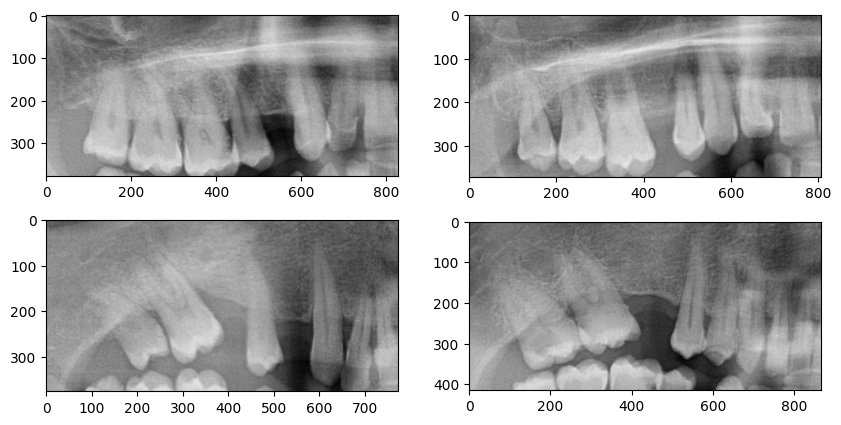

In [11]:
# sanity check

ax = plt.subplots(2,2,figsize=(10,5))[1].flatten()

for i in range(4):
    image = cv2.imread(f"/raid/infolab/bhavyakohli/mmdet/Co-DETR/data/enumeration/quadrant_patches/train_283_{i}.png")
    for dic in [i for i in [j for j in annotations if j['image_id'] == 1] if i['category_id_1'] == i]:
        x_min, y_min, width, height = dic['bbox'][:]

        x_max = x_min + width
        y_max = y_min + height

        if dic["category_id_1"] == 0:
            color = (255, 0, 0)        #red
        elif dic["category_id_1"] == 1:
            color = (0, 255, 0)        #green
        elif dic["category_id_1"] == 2:
            color = (0, 0, 255)     #blue
        elif dic["category_id_1"] == 3:
            color = (0, 0,0)            #black
        thickness = 5
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0,255,0), thickness)

    ax[i].imshow(image)

In [12]:
for i in range(len(annotations)):
    for key in ['image_id', 'q_image_id', 'id', 'category_id_1', 'category_id_2']:
        annotations[i][key] = int(annotations[i][key])

In [13]:
for i in range(len(qpatches)):
    for key in ['image_id', 'id']:
        qpatches[i][key] = int(qpatches[i][key])

In [14]:
#putting all the lists of dictionaries together:
file3 = {'images': imagesinfo, 'q-patches': qpatches, 'annotations': annotations, 'categories_1': cat1, 'categories_2': cat2}

#dumping into json
with open(file3add, "w") as outfile:
        json.dump(file3, outfile)